<a href="https://colab.research.google.com/github/jdamaster/machineLearningDiplomat/blob/master/S15_Overfiting_ExplGradientsVanisGradients_Optimizers_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

<h1> Diplomado de Análisis de datos y Machine Learning en Python</h1>


El presente diplomado hace parte del centro de Big Data de la facultad de ciencias exactas y naturales (FCEN) de la Universidad de Antioquia.

Empecemos por usar la versión 2 de de tensor flow:

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


## 1. Problema del desvanecimiento/explosión del gradiente.

Como hemos visto, las redes neuronales son entrenadas usando el algoritmo del **descenso del gradiente estocástico** conjuntamente con el de **retroproyección** . 

Lo anterior consiste, en primer lugar, en el cálculo del error de la predicción realizada por el modelo y el uso de este error para estimar un gradiente que es usado para actualizar cada peso en la red, de tal forma que se reduzca el error en la siguiente iteración. Este error del gradiente es propagado hacia atrás a lo largo de la red, desde la salida a la capa de entrada.

Normalmente, se desea entrenar la red neuronal con muchas capas, con la intensión de que el incremento del número de capas aumente la capacidad predictiva de la red, haciéndola capaz de aprender un dataset de gran tamaño. Por otra parte, se espera también que al aumentar el número de capas se logre representar de forma eficiente funciones de mapeo más complejas de los datos de entrada a las predicciones a la salida de la red.

Un problema en el entrenamiento de redes con muchas capas, **deep neural networks**, es que el gradiente se **desvanece o explota** dramáticamente a medida que se propaga hacia atrás a lo largo de la red. En el caso del desvanecimiento del gradiente, el error alcanzado en las capas cercanas a la entrada puede ser tan pequeño que tenga un efecto despreciable. El desvanecimiento del gradiente dificulta saber en qué dirección se deben variar los parámetros para obtener una mejora en la función de coste.

El término del **desvanecimiento/explosión** del gradiente se refiera al hecho de que en un red neuronal alimentada hacia adelante el error retropropagado normalmente decrece (o incrementa) en función de la distancia desde la capa final.

Además del problema de desvanecimiento, el error del gradiente puede ser instable en redes neuronales profundas, sufriendo cambios abruptos o explosiones, en donde el gradiente crece exponencialmente a medida que se propaga hacia atrás. Este problema se conce como problema del gradiente explosivo:

El problema de los gradientes que se desvanecen es un problema particular en las redes neuronales recurrentes, ya que la actualización de la red implica “desenrrollar” la red, creando una red muy profunda que requiere la actualización de los pesos. Una red neuronal recurrente modesta puede tener entre 200 a 400 pasos de tiempo de entrada, lo que resulta conceptialmente en una red muy profunda.

El problema de los gradientes que se desvanecen se puede manifestar en un perceptrón multicapas mediante una rata baja de la mejora del modelo durante el entrenamiento, y, quizas, en una convergencia temprana, es decir, el entrenamiento continuo no implica una mejora de la precisión del modelo. La inspección de los cambios de los pesos durante el entrenamiento, nos debería llevar a mayores cambios (que implica un mayor aprendizaje) en las capas cercanas a la salida  y cambios menores en las capas para cada paso de tiempo de entrada. 

Existen varias técnicas que pueden ser usadas para reducir el impacto de los gradientes que se desvanecen en el caso de redes neuronales alimentadas hacia adelante, los más notables de ellos son :

-	Los esquema de inicialización de pesos alternantes.
-	El uso de funciones de activación alternativas.
Se han estudiado diferentes aproximaciones para el entrenamiento de redes neuronales profunda (tanto para redes alimentadas hacia adelante como las recurrentes), en un esfuerzo para abordar los gradientes que se desvanecen, como el pre-entrenamiento, una mejora en el escalado aleatorio inicial, las mejoras en los métodos de optimización, el estudio de arquitecturas específicas, las inicializaciones ortogonales, etc.

En esta sección echaremos una mirada más cerca al uso de funciones de activación y esquemás alternativos de inicialización de los pesos, para poder entrenar redes neuronales más profundas. 


## Problema inducido por la funciones de activación:

Como vimos en la clase anterior, el algoritmo de retropropagación requiere de las derivadas de las funciones de activación, lo que implica que algunas de ellas favorecen el desvanecimento del gradiente.

Veamos que ocurre con las derivadas de las funciones de activación usadas en las capas ocultas.

### Función sigmoide:

La función sigmoide se define de la forma 

$$S(x)=\frac{1}{1+e^{-x}}$$

en donde la gráfica tiene la siguiente forma:

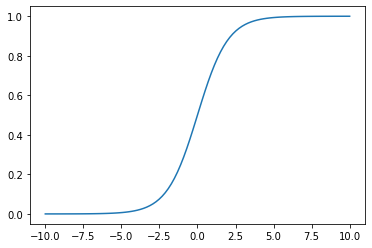

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
  return 1/(1+np.exp(-x))

x = np.linspace(-10,10,100)

plt.plot(x,sigmoid(x),'-')

La cual tiene un rango definido en el intervalo abierto $(-1,1)$.

La derivada de esta función, podemos calcularla como:

In [0]:
from sympy import *

x = Symbol('x')
f = 1/(1+exp(-x))
f.diff(x)

exp(-x)/(1 + exp(-x))**2

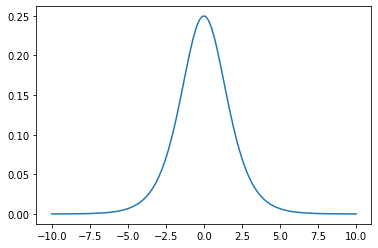

In [0]:
def sigmoid_deff(x):
  return np.exp(-x)/(1 + np.exp(-x))**2

x = np.linspace(-10,10,100)
plt.plot(x,sigmoid_deff(x),'-')

Veamos además, que el mapero de la función de activación **sigmoide** genera una concentración en las colas de la función, en donde la derivada se hace cero:

Text(0.5, 1.0, 'Derivada de la función de Activación sigmoide')

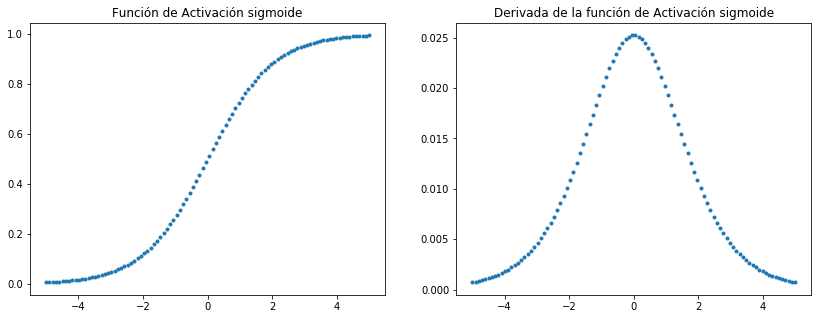

In [0]:
import tensorflow as tf
from tensorflow import keras

x=np.linspace(-5,5,100)

y_sigmoid = keras.activations.sigmoid(x)

y_sigmoid_diff = np.gradient(y_sigmoid)

plt.figure(figsize=(14,5))

plt.subplot(121)
plt.plot(x,y_sigmoid,'.')
plt.title('Función de Activación sigmoide')
plt.subplot(122)
plt.plot(x,y_sigmoid_diff,'.')
plt.title('Derivada de la función de Activación sigmoide')

**Problemas de la función sigmoide:**

**1) Desvanecimiento del gradiente:** Vemos que la derivada de esta función es cero en todas partes, excepto en el ancho representado por la gaussian. Lo anterior representa el caso a favor del desvanecimiento del gradiente. Por este motivo, la función tangente hiperbólica fue usada en su lugar.

**2) Función no centrada en cero:** La función sigmoide representa una función no centrada en cero, generando un valores positivos después de que la activación tenga lugar. Sin entrar en detalles, este hecho ocaciona que el gradiente de los pesos los convierta a todos en positivos o negativos, lo que dificulta la actualización del gradiente, comportándose de forma errativa. A este problema se le conoce como el [problema de funciones no centradas en cero](https://stats.stackexchange.com/questions/237169/why-are-non-zero-centered-activation-functions-a-problem-in-backpropagation).

#### Función de activación Tanh:

La función de activación tangente hiperbólica se define como:

$$\text{Tanh}(x)=\frac{e^x-​e^{​‑x}}{e^x+​e^{‑x}}$$

cuya gráfica es:

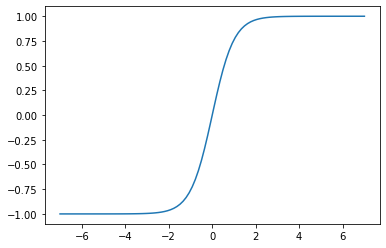

In [0]:
x = np.linspace(-7,7,100)

plt.plot(x,np.tanh(x),'-')

Cuyo rango es el intervalo abierto $(0,1)$.

La derivada de esta función es:

In [0]:
x = Symbol('x')
f = (exp(x)-exp(-x))/(exp(x)+exp(-x))
f.diff(x)

(-exp(x) + exp(-x))*(exp(x) - exp(-x))/(exp(x) + exp(-x))**2 + 1

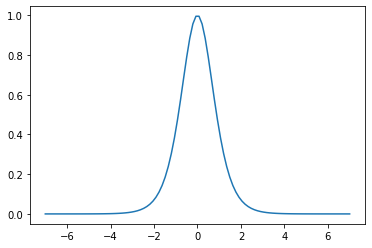

In [0]:
def tanh_diff(x):
  return (-np.exp(x)+np.exp(-x))*(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))**2 + 1

x = np.linspace(-7,7,100)

plt.plot(x,tanh_diff(x),'-')

Veamos además, que el mapeo de la función de activación la función **tanh** genera una concentración de puntos en las colas de la función, en donde su derivada se hace cero:

Text(0.5, 1.0, 'Derivada de la función de Activación Tanh')

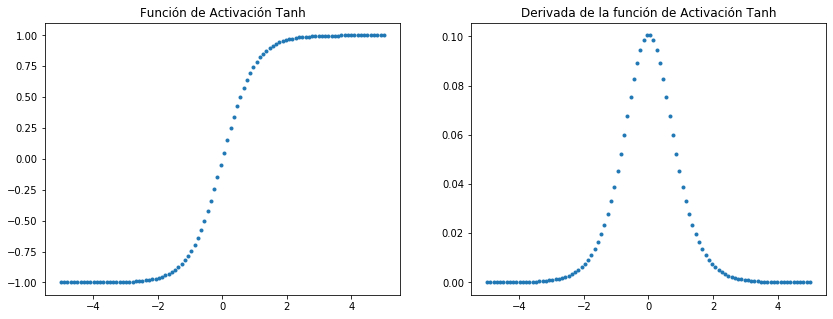

In [0]:
# función tanh
x=np.linspace(-5,5,100)

y_tanh = np.tanh(x)

#Derivada
y_tanh_diff = np.gradient(y_tanh)

# Gráfica de la función de activación y su derivada:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.plot(x,y_tanh,'.')
plt.title('Función de Activación Tanh')
plt.subplot(122)
plt.plot(x,y_tanh_diff,'.')
plt.title('Derivada de la función de Activación Tanh')

**Problemas de la función de activación tanh**

**1) Desvanecimiento del gradiente:** A pesar de se ha demostrado que el desempeño de la función de activación es mejor, dado su rango $(-1,1)$, la derivada de esta función es cerro en todo el dominio, excepto dentro de un intervalo pequeño centrado en el origen y determinado por el ancho de la gaussiana. Problema similar al de la función sigmoide.


### Función de activación ReLU:

Con el fin de corregir el problema introduccido por el desvanecimiento del gradiente al usar las funciones de activación **sigmoide** y **tangente hiperbólica**, se introduce la función **ReLU**.

Vemos las características de esta función y su derivada:

Text(0.5, 1.0, 'Derivada de la función de Activación ReLU')

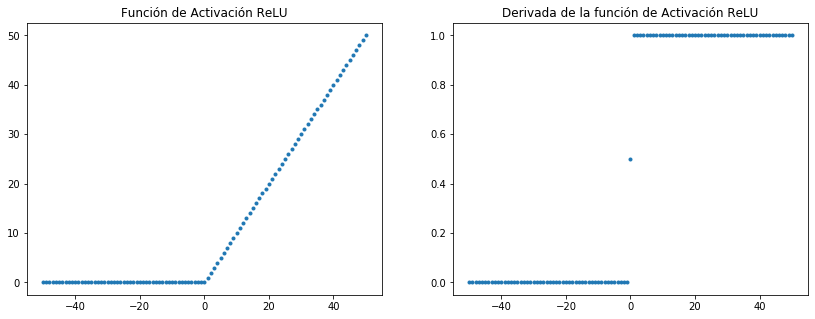

In [0]:
x=np.linspace(-50,50,101)

# Función de activación ReLU
y_relu = keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0.0)

# Derivada de la función de activación ReLU
y_relu_diff = np.gradient(y_relu)

# Gráfica de la función de activación ReLU y su derivada:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.plot(x,y_relu,'.')
plt.title('Función de Activación ReLU')
plt.subplot(122)
plt.plot(x,y_relu_diff,'.')
plt.title('Derivada de la función de Activación ReLU')


**Problemas de la función de activación ReLU**

**1) Dying ReLU:**  El problema principal de la función de activación ReLU está asociaado con el hecho de asignar un valor de cero a todos los valores negativos provenientes del ajuste lineal. Decimos que una neurona se encuentra muerta cuando el ajuste arroja valores negativos. Como vemos en la gráfica de la derivada ReLU, ésta es cero en los valores negativos de la función. Una vez que la neurona se vuelve "negativa", es muy poco probable que se recupere, y se convertirá en una neurona muerta. El problema de las neuronas muertas es que corresponenden a unidades inservibles, incapaces de contribuir en la clasificación. A este problema se le conoce con el nombre en inglés de [Dying ReLU](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7). Una solución a este problema es aplicar una función de activación conocida como LeakyReLU, la cual puede ser consultada en la referencia anterior y no abordaremos en este módulo.

A pesar de este problema, veremos que la función de activación resuelve el problema del desvanecimiento del gradiente en redes neuronales profundas. 

### Función de activación SeLU:

A continuación, hablaremos brevemente de la funciones SELU (Scaled Exponencial Linear Units), Las cuales aparecen por primenra ves en el siguiente
[artículo](https://arxiv.org/pdf/1706.02515.pdf).

Para una explicación detallada de la función de activación SELU, pueden consultar la siguiente 
[referencia](https://towardsdatascience.com/gentle-introduction-to-selus-b19943068cd9).

La forma de la función SELU y su derivada es la siguiente:


Text(0.5, 1.0, 'Derivada de la función de Activación ReLU')

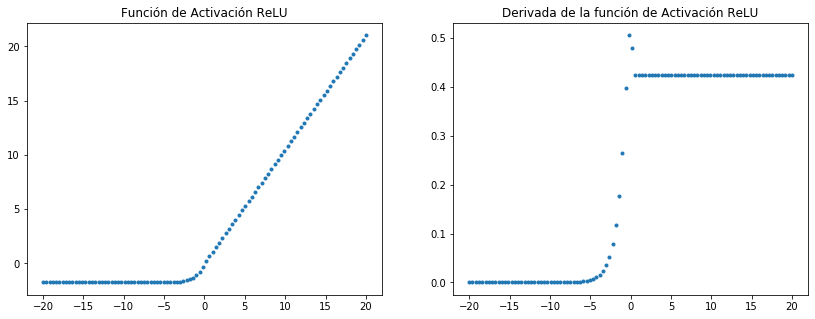

In [0]:
x=np.linspace(-20,20,100)

y_selu = keras.activations.selu(x)

y_selu_diff = np.gradient(y_selu)

plt.figure(figsize=(14,5))

plt.subplot(121)
plt.plot(x,y_selu,'.')
plt.title('Función de Activación ReLU')
plt.subplot(122)
plt.plot(x,y_selu_diff,'.')
plt.title('Derivada de la función de Activación ReLU')

De esta  gráfica podemos extraer dos características principales de la función de activación SELU:

1. El lado derecho de la función, es similaar a la función de activación ReLU.

2. El lado izquierdo, parace aproximarse a un gradiente zero, que es justo lo que queriamos evitar. No obstante la función SELU realiza un proceso aparte del control del gradiente conocído como **normalización**.

Respecto a la normalización podemos tener tres casos:

1. Que la normalización tenga lugar a la entrada de la red, por ejemplo cuando se reescala un intervalo de valor de píxeles que va de 0-255 a uno entre 0-1. Este tipo de normalización es una buena practica en ML.

2. En el caso de  NN, existe un normalización relevante conocida como **batch normalization**, la cual tiene lugar entre las capas de la red, transformandose las salidas de tal manera que el valor medio es cero y la desviación estándar sea uno. La principal ventaja de este procedimiento es que limita los valores y hace menos probable que ocurran valores extremales donde se hace cero la derivada. 

3. También en el caso de NN, la normalización puede tener lugar **internamente**, como en el caso de la función SELU. La idea principal es que cada capa preserva el valor medio y la varianza de la capa anterior, evitándose de esta forma valores extremales. 

**Problemas de la función SELU**

**1) Función reciente que necesita ser estudiada.**

**2) Requiere mucho costo computacional**

# Redes Neuronales Profundas

En las clases preventivas, introdujimos las redes neuronales artificiales y vimos algunos ejemplos de cómo entrenarlas. Pero estas eran redes muy poco profundas, con solo unas pocas capas ocultas. ¿Qué sucede si necesita abordar un problema muy complejo, como detectar cientos de tipos de objetos en imágenes de alta resolución? (Como ejemplo, considere el DIUx xView 2018 Detection Challenge http://xviewdataset.org/). Para estos casos, es posible que se necesite entrenar un DNN mucho más profundo, tal vez con 10 capas o mucho más, cada una con cientos de neuronas, conectadas por cientos de miles de conexiones. Aparecerán algunos problemas cuando intentes entrenar redes neuronales realmente profundas, algunos de ellos son:

* Vanishing gradients and exploding gradients que afecta las redes neuronales profundas y hace que las capas inferiores sean muy difíciles de entrenar.

* Es posible que no tenga suficientes datos de entrenamiento para una red tan grande, o puede ser demasiado costoso etiquetarlos.

* El entrenamiento puede ser extremadamente lento.

* un modelo con millones de parámetros correría el riesgo ha hacer overfitting, especialmente si no hay suficientes instancias de entrenamiento o si son demasiado ruidosas.

En esta lección veremos algunas técnicas para resolver estos problemas.



## Ejemplificación del desvanecimiento del gradiente:

A continuación haremos uso de un ejemplo de juguete para ilustrar el problema del desvanecimiento del gradiente dos gupos de puntos (clase 1 y clase 0) con una distribución circular.

Recordemos como crear un dataset a partir de la clase `make_circles` del módulo `datasets` de la librería `sklean`:

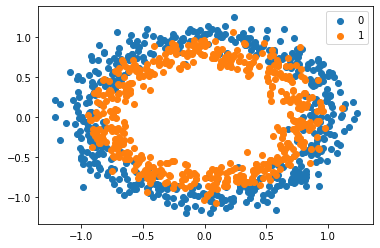

In [0]:
from sklearn.datasets import make_circles
import numpy as np
import matplotlib.pyplot as plt

# Generacíon de dos grupos de círculos.

X, y= make_circles(n_samples = 1000, noise=0.1, random_state=1)

# selección de las clases para graficarlas 
plt.scatter(X[y == 0, 0], X[y == 0, 1], label=str(0)) # extacción puntos según clase (0)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label=str(1)) # extacción puntos según clase (1)

plt.legend()
plt.show()

**Explicación del código:**

En la primeta parte buscamos todos indices con etiquetas`y==0` y etiquetas `y==1`. Para eso usamos la función de `numpy` `where`. Para el caso en que `y == 0`, tenemos que:

In [0]:
np.where(y == 0)

Si este array (tupla en realidad), se la pasamos en la indexación `X`, obtenemos las instancias (puntos `(X[idx,0],X[idx,1])`), tenemos los valores de las instancias para cada clase (0 y 1):

In [0]:
X[np.where(y==0)]

In [0]:
# Preprocesado de los datos:
from sklearn.preprocessing import MinMaxScaler
# scale input data to [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [0]:
# División de los datos en entrenamiento y evaluación
n_train = 500
train_X, test_X = X[:n_train, :], X[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

### Modelo del perceptrón multicapas para el problema de dos círculos:

Empecemos por ilustrar el caso en que temos un ajuste adecuado del modelo de de una red neuronal poco profunda consituida por una capa de entrada, con una función de activación `tanh` y una capa de salida `sigmoid`. Este modelo, no debe sufrir de problemas de desvanecimiento/explosión del gradiente:

Train: 0.798, Test: 0.822


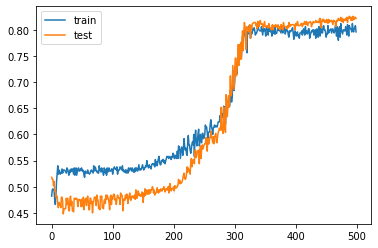

In [0]:
from tensorflow import keras

keras.backend.clear_session()

# Definición del modelo poco profundo
modelA= keras.models.Sequential()
init = keras.initializers.RandomUniform(minval=0, maxval=1)
modelA.add(keras.layers.Dense(5, input_dim=2, activation='tanh', kernel_initializer=init))
modelA.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init))

# Compilación del modelo
opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
modelA.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

# Ajuste del modelo:
history = modelA.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=500, verbose=0)

# evaluate the model
_, train_acc = modelA.evaluate(train_X, train_y, verbose=0)
_, test_acc = modelA.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [0]:
# selección de las clases para graficarlas 
plt.scatter(X[y == 0, 0], X[y == 0, 1], label=str(0)) # extacción puntos según clase (0)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label=str(1)) # extacción puntos según clase (1)

plt.legend()
plt.show()

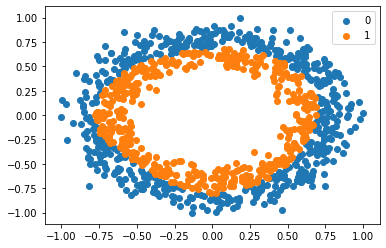

In [0]:
# selección de las clases para graficarlas 
y_pred=modelA.predict_classes(X)
y_pred=y_pred.reshape((-1))
plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], label=str(0)) # extacción puntos según clase (0)
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], label=str(1)) # extacción puntos según clase (1)

plt.legend()
plt.show()

### Creación de un modelo más profundo con fución de activación tanh:

Veamos ahora cómo un modelo de una red neuronal más profunda, genera un modelo menos predictivo devido al problema del desvanecimiento del gradiente. La red consta de una capa de entrada con un a función de activación `tanh`, y 4 capas ocultas, también definidas con una función de activación `tanh`, y una capa de salida con una función de activación `sigmoid`.



Train: 0.632, Test: 0.580


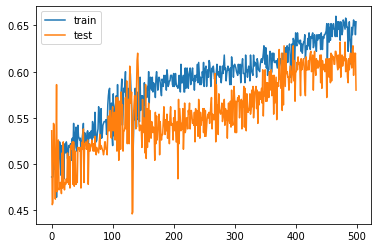

In [0]:
keras.backend.clear_session()

# define model
init = keras.initializers.RandomUniform(minval=0, maxval=1)
modelB = keras.models.Sequential()
modelB.add(keras.layers.Dense(5, input_dim=2, activation='tanh', kernel_initializer=init))
modelB.add(keras.layers.Dense(5, activation='tanh', kernel_initializer=init))
modelB.add(keras.layers.Dense(5, activation='tanh', kernel_initializer=init))
modelB.add(keras.layers.Dense(5, activation='tanh', kernel_initializer=init))
modelB.add(keras.layers.Dense(5, activation='tanh', kernel_initializer=init))
modelB.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init))
# compile model
opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
modelB.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = modelB.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=500, verbose=0)
# evaluate the model
_, train_acc = modelB.evaluate(train_X, train_y, verbose=0)
_, test_acc = modelB.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

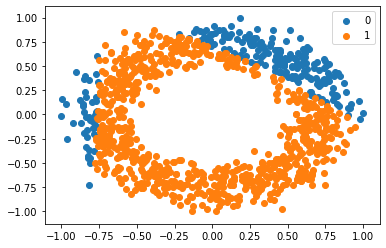

In [0]:
# selección de las clases para graficarlas 
y_pred=modelB.predict_classes(X)
y_pred=y_pred.reshape((-1))
plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], label=str(0)) # extacción puntos según clase (0)
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], label=str(1)) # extacción puntos según clase (1)

plt.legend()
plt.show()

### Creación de un modelo más profundo con fución de activación ReLU:

Ilustremos ahora cómo, con el simple hecho de cambiar las función de activación de la capa de entrada y las capas ocultas del anterior modelo por una función de activación `ReLU`, se mejora el problema del desvanecimiento del gradiente:

Train: 0.856, Test: 0.852


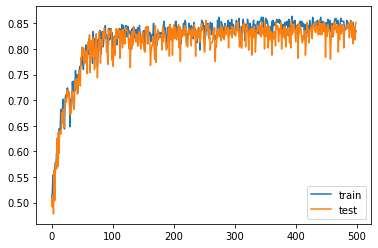

In [0]:
keras.backend.clear_session()

# define model
modelC = keras.models.Sequential()
modelC.add(keras.layers.Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
modelC.add(keras.layers.Dense(5, activation='relu', kernel_initializer='he_uniform'))
modelC.add(keras.layers.Dense(5, activation='relu', kernel_initializer='he_uniform'))
modelC.add(keras.layers.Dense(5, activation='relu', kernel_initializer='he_uniform'))
modelC.add(keras.layers.Dense(5, activation='relu', kernel_initializer='he_uniform'))
modelC.add(keras.layers.Dense(1, activation='sigmoid'))
# compile model
opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
modelC.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = modelC.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=500, verbose=0)
# evaluate the model
_, train_acc = modelC.evaluate(train_X, train_y, verbose=0)
_, test_acc = modelC.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

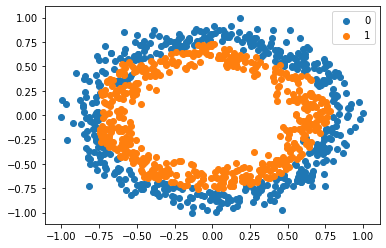

In [0]:
# selección de las clases para graficarlas 
y_pred=modelC.predict_classes(X)
y_pred=y_pred.reshape((-1))
plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], label=str(0)) # extacción puntos según clase (0)
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], label=str(1)) # extacción puntos según clase (1)

plt.legend()
plt.show()

Finalmente, veamos que las funciones de activación `SeLU`, también  ayudan a resolver el problema del desvanecimiento/explosión del gradiente:

Train: 0.836, Test: 0.838


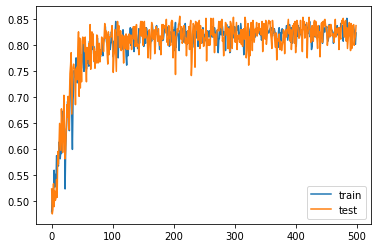

In [0]:
keras.backend.clear_session()

# define model
modelE = keras.models.Sequential()
modelE.add(keras.layers.Dense(5, input_dim=2, activation='selu', kernel_initializer='lecun_normal'))
modelE.add(keras.layers.Dense(5, activation='selu', kernel_initializer='lecun_normal'))
modelE.add(keras.layers.Dense(5, activation='selu', kernel_initializer='lecun_normal'))
modelE.add(keras.layers.Dense(5, activation='selu', kernel_initializer='lecun_normal'))
modelE.add(keras.layers.Dense(5, activation='selu', kernel_initializer='lecun_normal'))
modelE.add(keras.layers.Dense(1, activation='sigmoid'))
# compile model
opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
modelE.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = modelE.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=500, verbose=0)
# evaluate the model
_, train_acc = modelE.evaluate(train_X, train_y, verbose=0)
_, test_acc = modelE.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

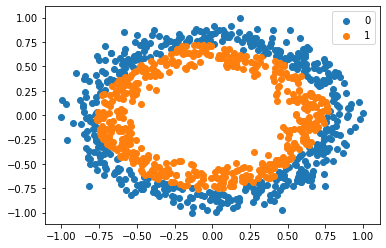

In [0]:
# selección de las clases para graficarlas 
y_pred=modelE.predict_classes(X)
y_pred=y_pred.reshape((-1))
plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], label=str(0)) # extacción puntos según clase (0)
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], label=str(1)) # extacción puntos según clase (1)

plt.legend()
plt.show()

# Recapitulación del problema del desvanecimiento/explosión del gradiente.

Cuando se realiza la propagación hacia atrás, los gradientes a menudo se hacen cada vez más pequeños a medida que el algoritmo avanza hacia las capas inferiores. Como resultado, el algoritmo de Descenso de degradado deja los pesos de conexión de la capa inferior prácticamente sin cambios, y el entrenamiento nunca converge en una buena solución. Esto es lo que se conoce como Vanishing Gradients Problems. En algunos otros casos, puede suceder lo contrario: los gradientes pueden crecer más y más, por lo que muchas capas obtienen actualizaciones de peso increíblemente grandes y el algoritmo diverge. Esto es lo que se conoce como Exploding Gradients Problems.  


Aunque este comportamiento se ha observado empíricamente durante bastante tiempo (fue una de las razones por las que las redes neuronales profundas fueron abandonadas durante mucho tiempo), apenas alrededor de 2010 se logró un progreso significativo en su comprensión. Xavier Glorot y Yoshua Bengio descubrieron que el problema estaba en la combinación de la popular función de activación sigmoid (y tambien la hyperbolica aunque en menor medida) y la técnica de inicialización de pesos que era más popular en ese momento (la inicialización aleatoria usando una distribución normal con una media de 0 y un estándar desviación de 1).

<p><img alt="Colaboratory logo" height="300px" src="https://i.imgur.com/Dbt0lIL.png" align="center" hspace="10px" vspace="0px"></p> 


# Inicialización de Glorot and He

Glorot y Bengio proponen una forma de aliviar significativamente este problema. Argumentan que necesitamos la varianza de la
Las salidas de cada capa deben ser iguales a la varianza de sus entradas, y también necesitamos que los gradientes tengan la misma varianza antes y después de fluir a través de una capa en la dirección inversa. En realidad, no es posible garantizar ambos a menos que la capa tenga el mismo número de entradas y neuronas (que en general no es cierto), pero propusieron una buena solución que ha demostrado funcionar muy bien en la práctica: los pesos de cada capa (para el caso de la funcion de activacion sigmoid) deben inicializarse aleatoriamente como (Esta es la inicialización de Glorot):

Distribución normal con media 0 y varianza
\begin{equation}
\sigma^2 = \frac{1}{fan_{avg}}
\end{equation}

O una distribución uniforme entre $−r$ and $+r$,
\begin{equation}
r = \sqrt{\frac{3}{fan_{avg}}} = \sqrt{3\sigma^2}
\end{equation}


donde 


* $fan_{avg} = \frac{1}{2} (fan_{in} + fan_{out})$


* $fan_{in}$ es el numero de neuronas de entrada 

* $fan_{out}$ es el numero de neuronas de salida 


La estrategia de inicialización para la función de activación ReLUy sus variantes es (Esta es la inicialización de Glorot) :

Distribución normal con media 0 y varianza
\begin{equation}
\sigma^2 = \frac{2}{fan_{avg}}
\end{equation}

O una distribución uniforme entre $−r$ and $+r$,
\begin{equation}
r = \sqrt{\frac{6}{fan_{avg}}} = \sqrt{3\sigma^2}
\end{equation}

podemos resumir entonces la forma mas comun de inicialzar los pesos en la sigueinte tabla 

<p><img alt="Colaboratory logo" height="200px" src="https://i.imgur.com/hBQ26T3.png" align="center" hspace="10px" vspace="0px"></p> 






Por defecto, Keras usa la inicialización de Glorot con una distribución uniforme, pero esto puede ser cambiado. Veamos un ejemplo de como hacerlo

importemos algunas librerias que seran de utilidad

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.datasets import make_circles

Resolveremos el problema de las dos espirales, para esto comencemos con crear las espirales

In [0]:
def twospirals(n_points, noise=0.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

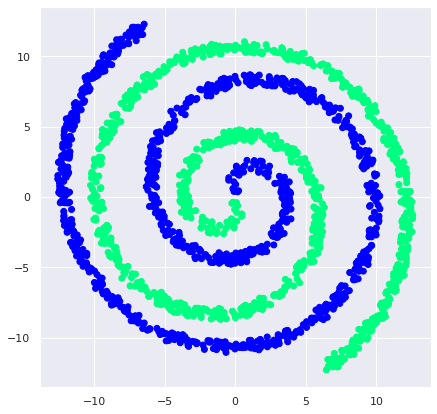

In [0]:
X, y =  twospirals(1000, noise=0.8)
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], c=y, cmap='winter')

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import datetime, os
keras.backend.clear_session()

Dividamos los datos en un set de entrenamiento y otro de testeo

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

escalemos los datos

In [0]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [0]:
X_train.shape

(1600, 2)

In [0]:
X_test.shape

(400, 2)

procedamos a construir nuestro modelo y a ilustrar como incializar los pesos de diferentes formas dependiendo la funcion de activacion

In [0]:
model = keras.models.Sequential([                                
                                keras.layers.Dense(40, activation='relu', kernel_initializer='he_normal',input_shape= (2,)),
                                keras.layers.Dense(12, activation='tanh',kernel_initializer='glorot_normal'),
                                keras.layers.Dense(40, activation='relu',kernel_initializer='he_uniform'),
                                keras.layers.Dense(12, activation='tanh',kernel_initializer='glorot_normal'),
                                keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
                                ])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(X_train,y_train, epochs=200 ,verbose=0)

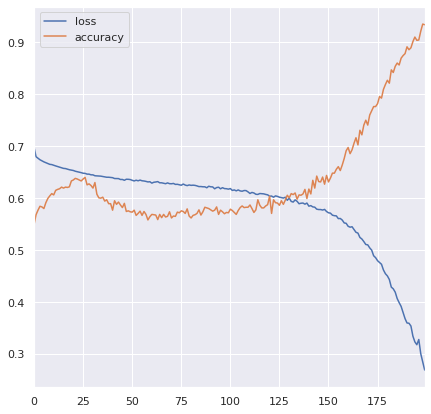

In [0]:
pd.DataFrame(history.history).plot(figsize=(7,7))

In [0]:
model.evaluate(X_test,y_test, verbose=0)

[0.27556735038757324, 0.9575]

In [0]:
y_fit =  model.predict_classes(X_test)

Text(0.5, 1.0, 'predicted_model')

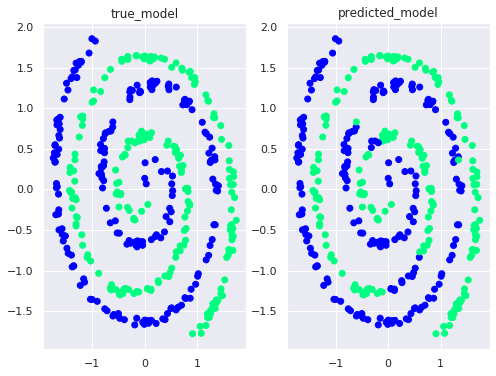

In [0]:
fig , ax = plt.subplots(1,2, figsize=(8,6))
ax[0].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='winter')
ax[0].set_title('true_model')
ax[1].scatter(X_test[:,0], X_test[:,1], c=y_fit[:,0], cmap='winter')
ax[1].set_title('predicted_model')

Por defecto, Keras implementa la inicialización He con una distribución uniforme basada en $fan_{in}$. Si desea la inicialización de He con una distribución uniforme pero basada en $fan_{avg}$, puede usar el inicializador VarianceScaling de esta manera:

In [0]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')

mas informacion de la versatilidad a la hora de inicializar los pesos puede ser encontrado en https://keras.io/initializers/

# **Regularización**

### **Introducción**
Muchas veces cuando entrenamos nuestro modelo y procedemos a validarlo, encontramos que este puede generalizar de una manera no totalmente correcta, es decir puede presentar overfitting. Como ya hemos visto existen multiples razones por las cuales esto se dé, poca cantidad de datos, una mala elección del modelo y su complejidad, entre otros.

<p><img alt="Colaboratory logo" height="200px" src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/Screen-Shot-2018-04-03-at-7.52.01-PM-e1522832332857.png" align="center" hspace="10px" vspace="0px"></p>


Una forma de evitar el overfitting es regularizando nuestro modelo, es decir poniendo ciertas restricciónes a nuestros parámetros de forma tal que se fuercen los parámetros a tomar valores pequeños, lo cual hará que la distribución de pesos sea más regular. Como se vió para regresiones, una de las formas de regularizar nuestro modelo era añadiendo un término a la función de costo, el cual de acuerdo a la forma de este, definía el tipo de regularización (**Ridge, lasso, Elasticnet**); o bien deteniendo el entrenamiento cuando el error de validación alcanzaba el mínimo, **Early stopping**.



Veamos como se puede usar los diferentes tipos de regularización y como se puede realizar su implementación en redes neuronales profundas.


### **Regularización L1 y L2**

Los métodos más simples de regularización son $l1$ y $l2$, los cuales consisten en añadir un término a nuestra función de costo, el cual dependerá de cual de los dos estemos usando, para así castigar los valores grandes de los parámetros en nuestra matriz de pesos y así restringirlos a pequeños valores. Esta tendra la siguiente forma aproximada:

\begin{equation}
J(W,b)=\frac{1}{m}\sum_{i}^{m}L(\hat{y}^{(i)},y^{(i)}) + regularización(W)
\end{equation}

Como vemos la regularización se realizará sobre los pesos de la red sin incluir el término de sesgo o inclinación "b" (bias term), esto se debe a que la mayoría de valores se encuentran en "W".

Para el caso de **$l2$** tenemos la siguiente forma para la matriz de costo

\begin{equation}
J(W,b)=\frac{1}{m}\sum_{i}^{m}L(\hat{y}^{(i)},y^{(i)}) + \frac{\lambda}{2m}\sum_{l=1}^{L}||W^{[l]}||^{2}_{F}
\end{equation}

Donde el término de regularización es una suma sobre la norma de frobenius, que básicamente es elevar al cuadrado las componentes de la matriz de pesos, a esta forma de regularización también se le conoce como **weight decay**.

De forma similar para **$l1$** tenemos

\begin{equation}
J(W,b)=\frac{1}{m}\sum_{i}^{m}L(\hat{y}^{(i)},y^{(i)}) + \frac{\lambda}{2m}\sum_{l=1}^{L}||W^{[l]}||
\end{equation}

Donde en este caso en la suma tendremos los valores absolutos de las componentes de la matriz de pesos. Como hemos mencionado la regularización busca disminuir y evitar el overfitting, el cual puede presentarse en parte debido a la complejidad de nuestro modelo.

<p><img alt="Colaboratory logo" height="250px" src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/Screen-Shot-2018-04-04-at-1.53.35-AM.png" align="center" hspace="10px" vspace="0px"></p>

Como vemos $l1$ y $l2$ consisten en añadir terminos proporcionales a $\lambda$ (un hiperparámetro), que de acuerdo a su valor va a restringir nuestros pesos a ciertos pequeños valores. Recordemos que 

\begin{equation}
Z=W^{T}X + b
\end{equation}

Si tenemos pesos pequeños, esto implicará un $Z$ pequeño, debido a su proporcionalidad, y por lo tanto el efecto de la función de activación estará restringido a valores pequeños, lo cual podemos traducir como una disminución en la complejidad del modelo,que es lo buscado.

<p><img alt="Colaboratory logo" height="250px" src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/Screen-Shot-2018-04-04-at-1.53.40-AM.png" align="center" hspace="10px" vspace="0px"></p>

De nuevo, esta calibración será guiada por el hiperparámetro $\lambda$, pues de no tener un valor correcto para este podemos caer incluso en el underfitting, cuando lo que se busca es el mejor modelo posible.

<p><img alt="Colaboratory logo" height="250px" src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/Screen-Shot-2018-04-03-at-10.37.28-PM.png" align="center" hspace="200px" vspace="0px"></p>

Cuando usamos keras, una forma de llamar el regularizador es la siguiente

In [0]:
from tensorflow import keras

In [0]:
layer = keras.layers.Dense(100, activation="elu",kernel_initializer="he_normal",
                            kernel_regularizer=keras.regularizers.l2(0.01))

Donde si necesitamos aplicar l1 usamos **keras.regularizers.l1()** o si deseamos usar ambos **keras.regularizers.l1_l2()**, donde el argumento sería el valor para $\lambda$.


## **Dropout**

Es uno de lo métodos mas usados como regularizador en redes neuronales. Fue propuesto por Geoffrey Hinton en el  2012. Dropout consiste en que en cada paso de entrenamiento se quitarán ciertas neuronas de nuestra red, es decir se tendrá cierta probabilidad "**P**" de que una neurona sea quitada o apagada (hacerla cero) durante ese paso del entrenamiento, para esto se tendrá en cuenta la capa de entrada y se excluíra la capa de salida.

<p><img alt="Colaboratory logo" height="150px" src="https://miro.medium.com/max/1354/1*skMXofkjeXtKzSr5lqIEmg.png" align="center" hspace="10px" vspace="0px"></p>

El hiperparámetro "**P**" es llamado **dropout rate**, normalmente tiene un valor entre $0.2$ y $0.5$, es decir, si tomamos 0.2, $1$ de $5$ unidades serán quitadas. Si ciertas neuronas en un paso son desactivadas, al siguiente no necesariamente lo estarán, pues de nuevo se tendrán en cuenta a la hora de hacer la desactivación en el nuevo paso del entrenamiento. Es importante aclarar que el **dropout** solo se realizará durante la etapa de entrenamiento, no en la de validación.

Este método de regularización es altamente usado pues se comporta como un **ensemble**, es decir, como la unión de varios modelos, esto puede ser interpretado de esta manera, pues en cada paso del entrenamiento al tener diferentes neuronas desactivadas, esto "equivale" a tener diferentes redes neuronales. Su implementación en keras es la siguiente

In [0]:
model = keras.models.Sequential([
                  keras.layers.Flatten(input_shape=[28, 28]),
                  keras.layers.Dropout(rate=0.2),
                  keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
                  keras.layers.Dropout(rate=0.2),
                  keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
                  keras.layers.Dropout(rate=0.2),
                  keras.layers.Dense(10, activation="softmax")
])

Donde en esta implementación vemos que se usó **keras.layers.Dropout**, donde durante el entrenamiento keras quita algunas de las entradas(haciendolas cero). 


### **Regularización de norma máxima (Max-norm)**

Es una forma de regularización muy usada en redes neuronales la cual consiste en restringir los valores de los pesos a cierto valor máximo, **r**, el cual es su hiperparámetro. En este caso no se le añade ningún término a la función de costo, en vez de eso se cálcula $|\textbf{w}|_{2}$ en cada paso y si se supera el valor límite se reescalan los valores de la siguiente forma:
\begin{equation}
\textbf{w} \leftarrow \textbf{w}\frac{r}{|\textbf{w}|_{2}} 
\end{equation}

Reucir el **r** implica incrementar la cantidad de regularización, lo cual puede ayudar con el overfitting. Su implementación en Keras es en la siguiente manera

In [0]:
keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                    kernel_constraint=keras.constraints.max_norm(1.))

### **Early Stopping**

Este  es un tipo de método de validación cruzada, el cual conciste en analizar el conjunto de validación y en el momento en que su error empiece a aumentar detener el entrenamiento. [callbacks](https://keras.io/callbacks/)

<p><img alt="Colaboratory logo" height="250px" src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/Screen-Shot-2018-04-04-at-12.31.56-AM.png" align="center" hspace="10px" vspace="0px"></p>


En keras se puede aplicar este método, haciendo uso de los *callbacks*, los cuales me permiten monitorear él codigo e interactuar con el proceso de entrenamiento de forma automática.

In [0]:
from keras.callbacks import EarlyStopping

EarlyStopping(monitor='val_err', patience=5)

## **Ejemplo**: Con regularización l1
Veamos un ejemplo guiado donde apliquemos regularización, a un dataset(**poker hand dataset**) que contiene manos de poker (5 cartas), donde cada carta se describe usando dos atributos (suit and rank), por lo tanto por cada mano tenemos 10 atributos, los cuales se definen de la siguiente manera.


1) S1 "Suit of card #1"
Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

2) C1 "Rank of card #1"
Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

3) S2 "Suit of card #2"
Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

4) C2 "Rank of card #2"
Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

5) S3 "Suit of card #3"
Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

6) C3 "Rank of card #3"
Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

7) S4 "Suit of card #4"
Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

8) C4 "Rank of card #4"
Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

9) S5 "Suit of card #5"
Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

10) C5 "Rank of card 5"
Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

11) CLASS "Poker Hand"
Ordinal (0-9)
 
  * 0: Nothing in hand; not a recognized poker hand 
    * 1: One pair; one pair of equal ranks within five cards
    * 2: Two pairs; two pairs of equal ranks within five cards
    * 3: Three of a kind; three equal ranks within five cards
    * 4: Straight; five cards, sequentially ranked with no gaps
    * 5: Flush; five cards with the same suit
    * 6: Full house; pair + different rank three of a kind
    * 7: Four of a kind; four equal ranks within five cards
    * 8: Straight flush; straight + flush
    * 9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush

 Carguemos las librerías que usaremos y llamemos los datos.

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

In [0]:
data_train=pd.read_csv('https://raw.githubusercontent.com/diplomado-bigdata-machinelearning-udea/Curso2/master/Datasets/poker-hand-training-true.data',
                       names=['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5','hand'])
data_test=pd.read_csv('https://raw.githubusercontent.com/diplomado-bigdata-machinelearning-udea/Curso2/master/Datasets/poker-hand-testing.data',
                      names=['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5','hand'])

In [0]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

Ahora, vamos a definir quien será nuestra matriz de atributos y cual será nuestro vector de etiquetas, tanto en el conjunto de entrenamiento como de prueba.

In [0]:
X=data_train.iloc[:,:-1].values
Y=data_train['hand'].values
X2=data_test.iloc[:,:-1].values
Y2=data_test['hand'].values

In [0]:
X_train_s= scaler.fit_transform(X)
X_test_s = scaler.fit_transform(X2)

#### Intenta construir una red neuronal profunda con dos capas ocultas, con 100 y 80 neuronas, cuya función de activación sea  'relu' y en su capa de salida una softmax, compilala usando el optimizador adam

In [0]:
model=keras.models.Sequential()
model.add(keras.layers.Dense(100,activation='relu',input_dim=10))
model.add(keras.layers.Dense(80,activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#### Ahora haz un fit con nuestros datos de entrenamiento, en los cuales uses un 30% para validación y gráfica las curvas de validación

In [0]:
history1=model.fit(X_train_s,Y,epochs=50,validation_split=0.3,shuffle=False)

Train on 17507 samples, validate on 7503 samples
Epoch 1/50
17507/17507 [==============================] - 2s 91us/sample - loss: 1.0303 - acc: 0.5150 - val_loss: 0.9649 - val_acc: 0.5317
Epoch 2/50
17507/17507 [==============================] - 1s 68us/sample - loss: 0.9584 - acc: 0.5453 - val_loss: 0.9584 - val_acc: 0.5357
Epoch 3/50
17507/17507 [==============================] - 1s 66us/sample - loss: 0.9501 - acc: 0.5479 - val_loss: 0.9566 - val_acc: 0.5361
Epoch 4/50
17507/17507 [==============================] - 1s 66us/sample - loss: 0.9445 - acc: 0.5497 - val_loss: 0.9557 - val_acc: 0.5375
Epoch 5/50
17507/17507 [==============================] - 1s 68us/sample - loss: 0.9396 - acc: 0.5499 - val_loss: 0.9552 - val_acc: 0.5389
Epoch 6/50
17507/17507 [==============================] - 1s 68us/sample - loss: 0.9353 - acc: 0.5532 - val_loss: 0.9543 - val_acc: 0.5399
Epoch 7/50
17507/17507 [==============================] - 1s 67us/sample - loss: 0.9309 - acc: 0.5561 - val_loss: 0.9

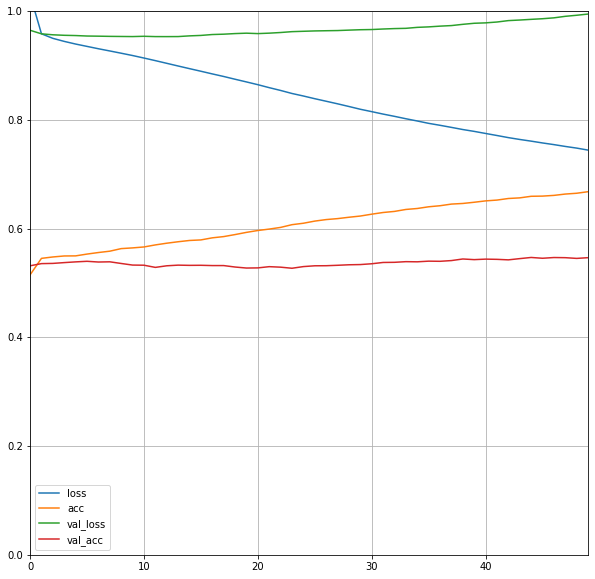

In [0]:
pd.DataFrame(history1.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

#### Crea un segunda red neuronal profunda en la cual utilizes el método de regularización L2, con su hiperparámetro igual a $0.002$. Compilalo con las mismas carácterisitcas de la red anterior y gráfica las curvas de validación.

In [0]:
model_2= keras.models.Sequential([
                  keras.layers.Dense(100,activation='relu',input_dim=10,kernel_regularizer=keras.regularizers.l2(0.002)),
                  keras.layers.Dense(80,activation='relu',kernel_regularizer=keras.regularizers.l2(0.002)),
                  keras.layers.Dense(10, activation="softmax")
])

In [0]:
model_2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
history2=model_2.fit(X_train_s,Y,epochs=50,validation_split=0.3,shuffle=False)

Train on 17507 samples, validate on 7503 samples
Epoch 1/50
17507/17507 [==============================] - 1s 73us/sample - loss: 1.1676 - acc: 0.5179 - val_loss: 1.0620 - val_acc: 0.5362
Epoch 2/50
17507/17507 [==============================] - 1s 68us/sample - loss: 1.0339 - acc: 0.5415 - val_loss: 1.0136 - val_acc: 0.5334
Epoch 3/50
17507/17507 [==============================] - 1s 67us/sample - loss: 0.9993 - acc: 0.5466 - val_loss: 0.9920 - val_acc: 0.5382
Epoch 4/50
17507/17507 [==============================] - 1s 67us/sample - loss: 0.9829 - acc: 0.5501 - val_loss: 0.9805 - val_acc: 0.5411
Epoch 5/50
17507/17507 [==============================] - 1s 67us/sample - loss: 0.9735 - acc: 0.5514 - val_loss: 0.9724 - val_acc: 0.5409
Epoch 6/50
17507/17507 [==============================] - 1s 67us/sample - loss: 0.9667 - acc: 0.5524 - val_loss: 0.9664 - val_acc: 0.5466
Epoch 7/50
17507/17507 [==============================] - 1s 69us/sample - loss: 0.9616 - acc: 0.5543 - val_loss: 0.9

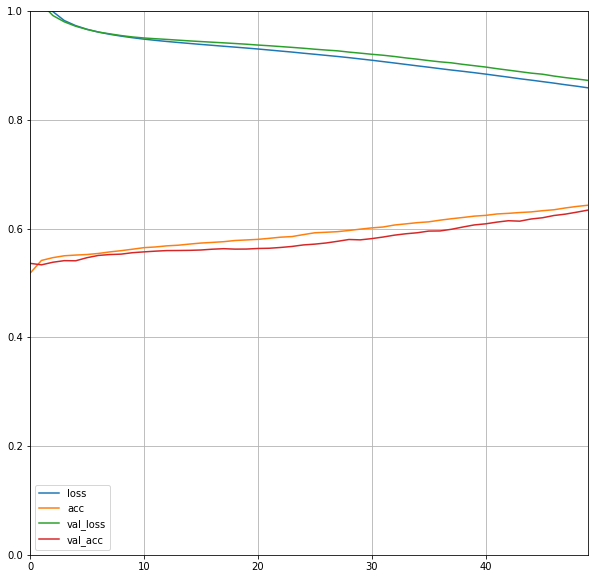

In [0]:
pd.DataFrame(history2.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## Gradient Clipping

**Ejercicio**: Entrene una red neuronal en keras para el dataset de Iris con 3 capas ocultas de 4 neuronas cada una con funciones de activación sigmoide. Use gradiente estocástico con **gradient clipping**

Haga click **aquí** si tiene problemas con la solución:

<!-----
from sklearn.datasets import load_iris
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD #Importar el optimizador
from keras.utils import to_categorical
data=load_iris()
X,y=data.data,data.target
X-=X.mean(axis=0)
X/=X.std(axis=0)
y=to_categorical(y)
modelo=Sequential()
modelo.add(Dense(4,activation='sigmoid',input_shape=(4,)))
modelo.add(Dense(4,activation='sigmoid'))
modelo.add(Dense(4,activation='sigmoid'))
modelo.add(Dense(3,activation='softmax'))
optim=SGD(clipnorm=1)
modelo.compile(optim,loss='categorical_crossentropy',metrics=['accuracy'])
modelo.summary()
modelo.fit(x=X,y=y, batch_size=10,epochs=500)
----->

## Funciones de Activación

**Ejercicio**: Entrene una red neuronal en keras para el dataset de Iris con 3 capas ocultas de 4 neuronas cada una con funciones de activación **ReLu**, **PReLU** y **SELU** respectivamente. Cuantos parámetros tendrá cada capa? 

In [0]:
keras.backend.clear_session()

# define model
modelE = keras.models.Sequential()
modelE.add(keras.layers.Dense(5, input_dim=2, activation='relu', kernel_initializer='lecun_normal'))
modelE.add(keras.layers.Dense(5, activation='prelu',))
modelE.add(keras.layers.Dense(5, activation='selu', ))
modelE.add(keras.layers.Dense(1, activation='softmax'))
# compile model
opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
modelE.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [0]:
# fit model
history = modelE.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=500, verbose=0)
# evaluate the model
_, train_acc = modelE.evaluate(train_X, train_y, verbose=0)
_, test_acc = modelE.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Haga click **aquí** si tiene problemas con la solución:

<!-----
from sklearn.datasets import load_iris
from keras.models import Sequential
from keras.layers import Dense,PReLU #Puedo importar las funciones
from keras.utils import to_categorical
data=load_iris()
X,y=data.data,data.target
X-=X.mean(axis=0)
X/=X.std(axis=0)
y=to_categorical(y)
modelo=Sequential()
modelo.add(Dense(4,activation='relu',input_shape=(4,)))
modelo.add(Dense(4))
modelo.add(PReLU())
modelo.add(Dense(4,activation='selu'))
modelo.add(Dense(3,activation='softmax'))
modelo.compile('sgd',loss='categorical_crossentropy',metrics=['accuracy'])
modelo.summary()
modelo.fit(x=X,y=y, batch_size=10,epochs=500)
----->

## Inicialización de Parámetros

**Ejercicio:** Entrene una red neuronal para el dataset iris con 3 capas ocultas de 4 neuronas cada una con función de activación ReLU e inicialización **Glorot Normal**.

Haga click **aquí** si tiene problemas con la solución:

<!-----
from sklearn.datasets import load_iris
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.initializers import glorot_normal #Importar el inicializador
data=load_iris()
X,y=data.data,data.target
X-=X.mean(axis=0)
X/=X.std(axis=0)
y=to_categorical(y)
glorotinit=glorot_normal()
modelo=Sequential()
modelo.add(Dense(4,activation='relu',kernel_initializer=glorotinit,input_shape=(4,)))
modelo.add(Dense(4,activation='relu',kernel_initializer='glorot_normal')) #puedo escribir simiplemente "glorot_normal"
modelo.add(Dense(4,activation='relu',kernel_initializer='glorot_normal'))
modelo.add(Dense(3,activation='softmax',kernel_initializer='glorot_normal'))
modelo.compile('sgd',loss='categorical_crossentropy',metrics=['accuracy'])
modelo.summary()
modelo.fit(x=X,y=y, batch_size=10,epochs=500)
----->

## Batch Normalization

**Ejercicio:** Entrene una red neuronal para el dataset iris con 3 capas ocultas de 4 neuronas cada una con función de activación ReLU y **Batch Normalization** en la segunda capa oculta.

Haga click **aquí** si tiene problemas con la solución:

<!-----
from sklearn.datasets import load_iris
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization #Importar BatchNorm
from keras.utils import to_categorical
data=load_iris()
X,y=data.data,data.target
X-=X.mean(axis=0)
X/=X.std(axis=0)
y=to_categorical(y)
modelo=Sequential()
modelo.add(Dense(4,activation='relu',input_shape=(4,)))
modelo.add(Dense(4,activation='relu'))
modelo.add(BatchNormalization())
modelo.add(Dense(4,activation='relu'))
modelo.add(Dense(3,activation='softmax'))
modelo.compile('sgd',loss='categorical_crossentropy',metrics=['accuracy'])
modelo.summary()
modelo.fit(x=X,y=y, batch_size=10,epochs=500)
----->

# Regularización

**Ejercicio:** Entrene una red neuronal para el dataset iris con 3 capas ocultas de 4 neuronas cada una con función de activación ReLU y **regularización L2** en los pesos y **regularización L1** en los bias.

Haga click **aquí** si tiene problemas con la solución:

<!-----
from sklearn.datasets import load_iris
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras.utils import to_categorical
from keras.regularizers import l1,l2 #Importar Regularizadores
data=load_iris()
X,y=data.data,data.target
X-=X.mean(axis=0)
X/=X.std(axis=0)
y=to_categorical(y)
l2_reg=l2()
l1_reg=l1(0.001)
modelo=Sequential()
modelo.add(Dense(4,activation='relu',kernel_regularizer=l2_reg,bias_regularizer=l1_reg,input_shape=(4,)))
modelo.add(Dense(4,activation='relu',kernel_regularizer='l2',bias_regularizer='l1')) #puedo simplemente escribir "l1" o "l2"
modelo.add(Dense(4,activation='relu',kernel_regularizer='l2',bias_regularizer='l1'))
modelo.add(Dense(3,activation='softmax',kernel_regularizer='l2',bias_regularizer='l1'))
modelo.compile('sgd',loss='categorical_crossentropy',metrics=['accuracy'])
modelo.summary()
modelo.fit(x=X,y=y, batch_size=10,epochs=500)
----->

# Optimizadores



Vimos que la técnica de propagación hacia atrás utiliza el gradiente de descenso para ealizar la optimización de los pesos en cada pasada.

La actualización mediante el gradiente de descenso lo hemos definico como:

$$w_{t}=w_{t-1}-\eta  \nabla C(w)$$

Donde $\eta$ es llamado la taza de aprendizaje, éste debe escogerse de tal forma que no sea tan pequeño como para hacer muy lenta la convergencia, ni muy grande como para hacer que nuestros pesos diverjan.

Uno de los  mayores incovenientes con éste algoritmo es que en el caso de las funciones de coste no convexas es probable quedar atrapado en un mínimo local, y jamás llegar a un mínimo global, para mitigar dicha posibilidad se han creado algunas variaciones como el gradiente de descenso estocástico o el gradiente de descenso por minibatch.

### Gradiente de descenso estocástico.

Como es planteado el gradiente de descenso solo hace un recalculo de los parámetros del modelo una vez ha hecho un paso completo de todos los ejemplos, ésto hace que el algorítmo sea de lenta convergencia y en caso de tener muchos ejemplos de entrenamiento pueda desbordar la memoria de la máquina.

En el gradiente estocástico se realiza una actualización cada que se ha entregado un ejemplo a la red, con eésto se consigue una mayor varianza y por tanto las actualizaciones fluctuan en intensidad y es más difícil que el algoritmo quede atrapado en un mínimo local si éste no es bastante "profundo" lo cual garantiza mínimos más estables.

### Gradiente de descenso por minibatch.

Una de las desventajas del SDG reside en que al hacer una actualización por ejemplo puede ser bastante lento, una solución intermedia es pasar unos cuantos ejemplos antes de hacer la actualización (entregar un batch), con ello aumentamos la velocidad de entrenamiento pero no perdemos la ventaja de generar varianza sobre las actualizaciones para evitar ser atrabados en un mínimo local.

Todos éstos métodos utilizan la mísma ecuación y la mísma idea de fondo, se diferencian en la cantidad de ejemplos pasados por la red antes de realizar la actualización de los pesos.






## Momentum.

Dado que los métodos de descenso de gradiente calculan las variaciones en todas direcciones suelen oscilar de forma innecesaria, lo cual hace que su convergencia sea más lenta. Para solucionar ésto se usa la técnica de momentum, en analogía con el momentum de la física clásica.

Cuando una pelota rudea por una pendiente su velocidad aumenta en la dirección de movimiento (su derivada), mientras que en las demás direcciones no lo hace. En el método se sigue la misma idea, la actualización se hará en las direcciones en las que el gradiente aumentó más la actualización pasada, así nos aseguramos de no actualizar (demasiado) los pesos de manera innecesaria en direcciones que no contribuyen a la busqueda del mínimo.

Si ahora notamos el paso de actualización de los pesos como: $$w_t = w_{t-1}-V(t)$$

El $V$ en la iteración $t$ estará dado por:

$$V(t) = \gamma V(t-1)+\eta \nabla (w)$$

Ahora tenémos un hiperparámetro nuevo $\gamma$ que se encargará de determinar qué tanto influencia la actualización pasada a la actual, generalmente será un número al rededor de $0.9$

## Gradiente acelerado de Nesterov.

En los años 80 el investigador Yurii Nesterov se dio cuenta que el momentum tenía un problema, al igual que en la analogía de la pelota, al llegar al mínimo el momento remanente empuja la pelota un poco más arriba del mínimo, también pasará lo mismo en el caso del error de la red, ésto puede demorar la convergencia o incluso hacer que el error no converja nunca. 

Para solucionar dícho problema Nasterov propuso no solo usar la influencia de la actualización pasada en la actualización presente si no que también se tendría en cuenta para el cálculo del gradiente (similar a tener en cuenta la aceleración para determinar que tan cerca se está de un cambio de direción).

Así tenemos que:

$$V(t) = \gamma V(t-1)+\eta \nabla (w- \gamma V(t-1))$$

Por tanto la actualización disminuirá su "momentum" al acercarce al mínimo y por tanto no se alejará mucho de él.

## Adagrad y Adadelta.

Adagrad (adaptative gradient) nos permite actualizar de manera adaptativa cada parámetro, haciendo grandes modificaciones a parámetros infrecuentes mientras que lo hará con más cuidado a parámetros frecuentes. Ésto será útil cuando tratemos con datos dispersos (sparse data). 

Cada parámetro $w_i$ será actualizado así:

$$w_{i,t} = w_{i,t-1}-\frac{\eta}{\sqrt{G_{ii}+\epsilon}}\frac{\partial C }{\partial  w_i}$$

El termino $G_{ii}$ es la acumulación de los gradientes pasados, $\epsilon$ es un número pequeño para evitar la divergencia al dividir por cero.

Un problema con ésta técnica es el hecho de que al acumular los gradientes en el denominador poco a poco el gradiente se hace más y más suave (también sufre de una especie de desvanecimiento) además de que el tiempo de entrenamiento también se hará mayor pues los pasos serán cada vez menores.

Para atacar el problema del desvanecimiento usaremos **Adadelta**, en éste caso no tomaremos toda la acumulación de gradientes si no que se hará con una ventana de tamaño $\rho$, definida por nosotros, con ello tenemos que el denominador será el RMS (sobre la vetana) de los gradientes, así:
$$w_{i,t} = w_{i,t-1}-\frac{\eta}{RMS(\frac{\partial C }{\partial  w_i})}\frac{\partial C }{\partial  w_i}$$

Ambas técnicas tienen la ventaja de no ser necesaria la definición de una razón de aprendizaje, ya que de manera iterativa ésta será calculada.

## Adam (Adaptative moment estimator).

Adam calculará tanto el promedio de los gradientes pasados  (como Adadelta), así como el promedio del decaimiento de los graientes pasados (como momentum).

Por tanto Adam es un estimador de momentos estadísticos adaptatico (en cada iteración). 

El primer momento acumulado será:
$$\hat{m} =\frac{m_t}{1-\beta_1^t}$$

y el segundo:
$$\hat{v} =\frac{v_t}{1-\beta_2^t}$$

y la actualización de los pesos será adaptada como:
$$w_{i,t} = w_{i,t-1}-\frac{\eta}{\hat{v}+\epsilon}\hat{m}$$

$\beta_i$ serpan hiperparámetros del optimizador.

Adam es uno de los mejores optimizadores ya que es rápido, evita las fluctuaciones exageradas de los parámetros en direcciones no convenientes, y el desvanecimiento de los gradientes.


![](https://miro.medium.com/max/620/1*XVFmo9NxLnwDr3SxzKy-rA.gif)

![](https://miro.medium.com/max/620/1*SjtKOauOXFVjWRR7iCtHiA.gif)

# Optimizadores en Keras.

Como sabemos, uno de los pasos fundamentales en Keras para definir y entrenar un modelo es compilarlo, allí debemos decidir cual será el método de optimización a usar, además de la función de perdida y las métricas a usar.

Los diferéntes optimizadores se importan como `from keras import optimizers` [https://keras.io/optimizers/](https://keras.io/optimizers/)

Allí encontraremos los anteriores (y unos cuantos más).

Podemos llamarlos en el compilador de dos maneras:



*   Instanciandolos antes del compilador. 
*   Llamandolos dentro del compilador.
Veamos:


In [0]:
from keras import optimizers

model = Sequential()
model.add(Dense(64, kernel_initializer='uniform', input_shape=(10,)))
model.add(Activation('softmax'))
#Instanciamos previo a llamarlo en el compilador, en éste caso podemos cambiar los parámetros del optimizador
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [0]:
#dando su nombre como parámetro al compilador, en éste caso los parámetros del optimizador usados serán sus valores por defecto
model.compile(loss='mean_squared_error', optimizer='sgd')

In [0]:
#Para llamar un gradiente estocástico
#Recuerden que la difencia estará en cómo pasemos los bathc, además podemos darle un momentum o un nesterov,
#SDG contiene entonces los optimizadores SDG, momentum, y Nesterov en una sola clase
keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)

In [0]:
#Adagrad se llamará como:
#el learning_rate es el valor inicial de dicho parámetro, 
#recuerde que éste método es adaptativo y éste valor cambiará con las iteraciones
keras.optimizers.Adagrad(learning_rate=0.01)

In [0]:
#Adadelta será:
#El parámetro $\rho$ controla la fracción de gradientes a tener en cuenta en cada paso de optimización.
keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)

In [0]:
#finalmente Adam
#donde amsgrad determina si se aplica una modificaión al método o no basada en https://openreview.net/forum?id=ryQu7f-RZ
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

Recuerde que cada optimizador tendrá sus ventajas o desventajas dependiendo del problema, la función de coste y nuestro poder computacional.
Por lo general el usdo de Adam o SDG con momentum serán una buena elección como primera prueba.

Finalmete, en todos los optimizadores es posible usar los parámetros clipnorm (todos los valores de los gradientes serán recortados a una norma máxima) y clipvalue (todos los valores de los gradientes serán recortados a un valor mínimo de -n y máximo de n)

In [0]:
#los valores de los gradientes estarán como máximo en una norma de 1
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
#los valores de los gradientes estarán mínimo en -0.5 y máximo en 0.5
sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)

**Ejercicio:** Entrene una red neuronal para el dataset iris con 3 capas ocultas de 4 neuronas cada una con función de activación ReLU inicializadando los pesos con glorot_normal y los bias en cero. Aplicar regularización L2 de los pesos y L1 de los bias. Adicionalmente, aplique Batch Normalization en la segunda capa oculta. Entrene la red usando el optimizador **Adam** con Gradient Clipping y usando un 20% como datos de validación. 

Haga click **aquí** si tiene problemas con la solución:

<!-----
from sklearn.datasets import load_iris
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
data=load_iris()
X,y=data.data,data.target
X-=X.mean(axis=0)
X/=X.std(axis=0)
y=to_categorical(y)
modelo=Sequential()
modelo.add(Dense(4,activation='relu',kernel_regularizer='l2',bias_regularizer='l1',kernel_initializer='glorot_normal',bias_initializer='zero',input_shape=(4,)))
modelo.add(Dense(4,activation='relu',kernel_regularizer='l2',bias_regularizer='l1',kernel_initializer='glorot_normal',bias_initializer='zero'))
modelo.add(BatchNormalization())
modelo.add(Dense(4,activation='relu',kernel_regularizer='l2',bias_regularizer='l1',kernel_initializer='glorot_normal',bias_initializer='zero'))
modelo.add(Dense(3,activation='softmax',kernel_regularizer='l2',bias_regularizer='l1',kernel_initializer='glorot_normal',bias_initializer='zero'))
optim=Adam(clipnorm=1)
modelo.compile(optim,loss='categorical_crossentropy',metrics=['accuracy'])
modelo.summary()
modelo.fit(x=X,y=y, batch_size=10,epochs=500,validation_split=0.2)
----->